# Applied Machine learning !

In this lab we will study a soccer dataset and apply Machine Learning to it. We will try to predict the skin color of a player given some of it's information

### Some useful imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

### First we import the dataset and study it :

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

How much data do we have ?

In [3]:
df.shape

(146028, 28)

Let's look at our columns

In [4]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
df.head().ix[:10,0:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
df.head().ix[:10,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [6]:
df[df.rater1 == df.rater2].shape

(95714, 28)

In [7]:
df["rater2"].unique()

array([ 0.5 ,  0.75,   nan,  0.  ,  0.25,  1.  ])

Thanks to the previous work of Mat Evans and Tom Stafford and their team (can be found here : http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb )

we know some of the specificities of the data :

- We learn that the data is organized in a player-referee dyad. This means each row has all the interaction with one player and a referee. For their analysis they decided to separate this dataset for each interaction between a player and a referee. For our purposes we will rather group by player short because we don't really care for referee information.

- The data about skin color is not consistent between the two raters and the picture is missing. For the picture we will just remove the data with no picture. As we need a way to attribute skin color to each player we will have to use the two raters. For this there are different ways we could go at it :
    - We could do a mean of the two raters
    - We could keep only the dyads which have the same score for r1 and r2
    - We could train on both raters and compare the result (seems a bit repetitive but why not)
    
- The raters data in the set [0, 0.25, 0.50, 0.75, 1] to classify "correctly" there are 3 possibilities :
    - The first one is to have a class for each number
    - The second is to have two classes with a cut at 0.5 (we have to define which class contain 0.5)
    - The third is to have 3 classes : $<0.5$, $0.5$, $>0.5$

- Finally we learn that there are dyads which are not really part of the 2012-2013 data but from past matches in the carrer of the player. Here we have a choice, either we remove the data because it's not really part of the dataset or we let it be as it could be more information.

Here is how we think of organizing this homework :
- First we will clean a bit the data
- Then we will aggregate the data per player
- Then we will for each point made above with multiple proposition see which one is the best, if multiple ones seem good we will keep them and test them with cross validation.
- Finally we will find the best result we can with all possible datasets with a random forest classifier.

## Removing non valid dyads from player past history

For a more detailed explanation of how we can show the fact that there are dyads from before 2012-2013 you can look here : http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb

To remove those dyad, the logic is to say that if a referee has participated in at least one match in the league he should have at least 22 appearances in the dataset.

The folowing code ressembles (as we use the same principles) the work previously mentioned. But as we will see some differences I will try and explain them as we go through the code to show we aren't doing anything wrong.

In [8]:
referee_b = df["refNum"].unique().shape[0]
print("number of unique referee before cleaning : ", referee_b) # here no differences

number of unique referee before cleaning :  3147


In [9]:
dyads_b = df.shape[0]
games_b = df.games.sum()
print("number of dyads before cleaning : ", dyads_b)
print("number of matches before cleaning : ", games_b) # same value as in the other notebook 
                                                     # (we will use it later as reference)

number of dyads before cleaning :  146028
number of matches before cleaning :  426572


This part shows the value that the others get :

In [10]:
apearances_tot = df[["refNum", "games"]].groupby("refNum").sum()

In [11]:
apearances_sup21_tot = apearances_tot[apearances_tot.games > 21]
apearances_sup21_tot.count() # same number of remaining referee as in the other notebook

games    1261
dtype: int64

In [12]:
df_sup21_tot = df[df["refNum"].isin(apearances_sup21_tot.index)]

In [13]:
referee_a_tot = df_sup21_tot["refNum"].unique().shape[0]
print("number of unique referee after removing : ", referee_a_tot)

number of unique referee after removing :  1261


In [14]:
dyads_a_tot = df_sup21_tot.shape[0]
games_a_tot = df_sup21_tot.games.sum()
print("number of dyads after removing : ", dyads_a_tot)
print("number of matches after removing : ", games_a_tot) # same number as in the other notebook 

number of dyads after removing :  137635
number of matches after removing :  415692


Now as our data is organized differently we use another method

Here is what will change most of the calculations result

In [15]:
apearances_once_player = df.refNum.value_counts()
len(apearances_once_player)

3147

This is the number of apearances with a slight twist, we only count one apearance per player whatever the number of match he played. For us this value is better to use in this case as it relates more to the >21 cut. Before we counted for a single referee a number of matches with the same player which makes no sense : in a match, a referee has 22 distinct players.

In [16]:
apearances_sup21_once_player = apearances_once_player[apearances_once_player > 21]
len(apearances_sup21_once_player) ## a bit less than before sadly

998

In [17]:
df_sup21_once_player = df[df["refNum"].isin(apearances_sup21_once_player.index.values)]

In [18]:
referee_a_once_player = df_sup21_once_player["refNum"].unique().shape[0]
print("number of unique referee after removing : ", referee_a_once_player)

number of unique referee after removing :  998


In [19]:
dyads_a_once_player = df_sup21_once_player.shape[0]
games_a_once_player = df_sup21_once_player.games.sum()
print("number of dyads after removing : ", dyads_a_once_player)
print("number of matches after removing : ", games_a_once_player) # a bit lower than before again

number of dyads after removing :  133501
number of matches after removing :  406924


Let's show how much data we lose

In [20]:
print("loss of games with their method :", games_a_tot / games_b)
print("loss of dyads with their method :", dyads_a_tot / dyads_b)
print("loss of refs with their method : ", referee_a_tot / referee_b)


loss of games with their method : 0.974494340932
loss of dyads with their method : 0.9425247212863287
loss of refs with their method :  0.40069907848744835


In [21]:
print("loss of games with our method :", games_a_once_player / games_b)
print("loss of dyads with our method :", dyads_a_once_player / dyads_b)
print("loss of refs with our method : ", referee_a_once_player / referee_b)

loss of games with our method : 0.953939780389
loss of dyads with our method : 0.914215082039061
loss of refs with our method :  0.3171274229424849


### Here we show some graphes to show the difference between the two methods.

Graph of occurences (source from http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)

We thought of using their graphs to have a good comparaison between their work and ours

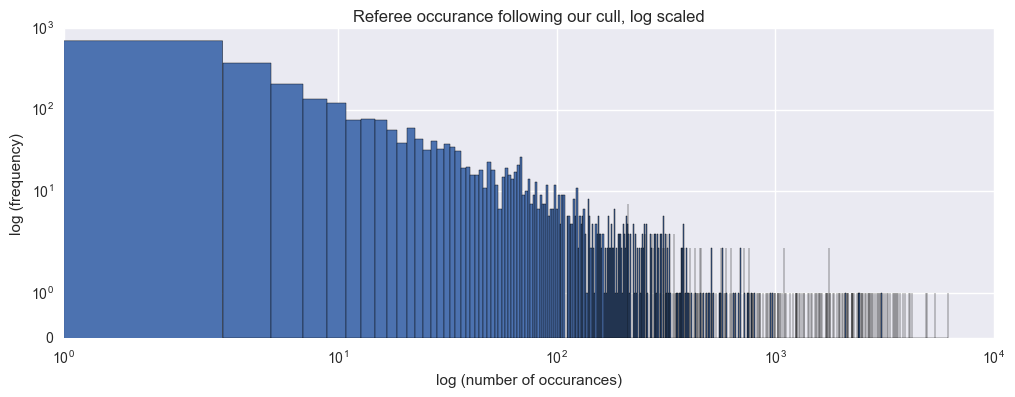

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

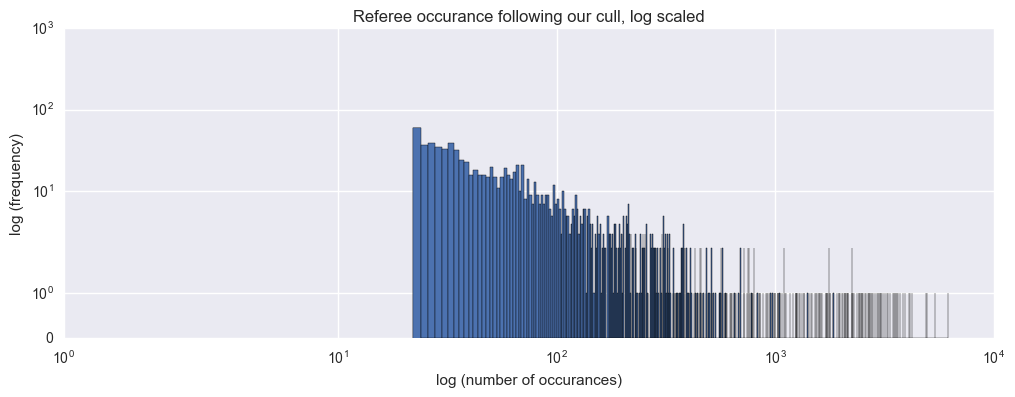

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df_sup21_tot[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

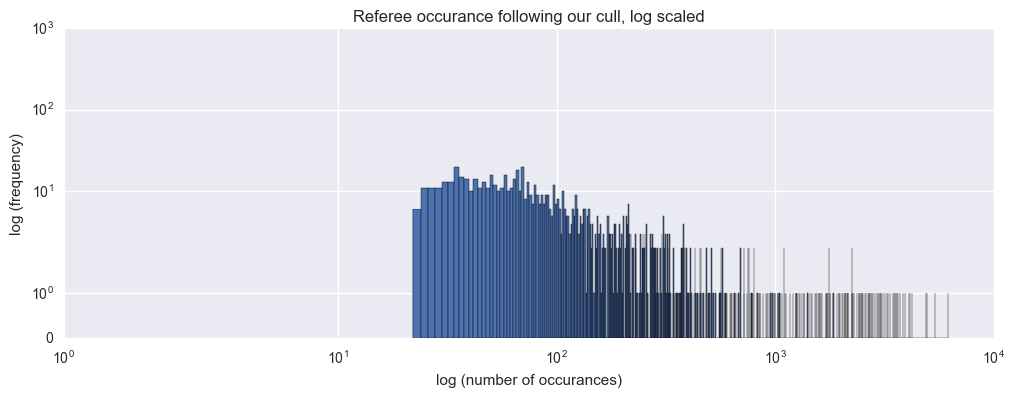

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(df_sup21_once_player[["refNum", "games"]].groupby("refNum").sum().games.tolist(),referee_b-11)
axes.set_xscale('symlog') # symetric log scale 
plt.xlim([1,10000])
axes.set_yscale('symlog') 
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel('log (number of occurances)')
axes.set_ylabel('log (frequency)')

We can clearly see here that we only remove the lowest occurences of the previous graph

(-3, 160)

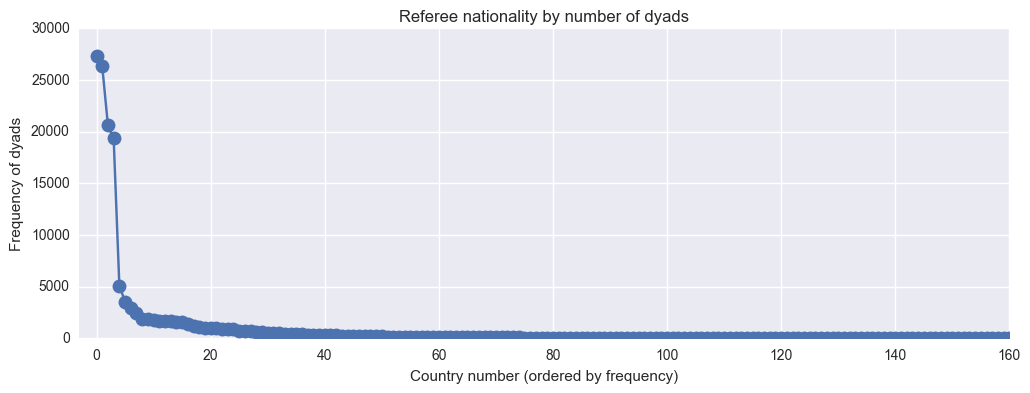

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist() 

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

(-3, 160)

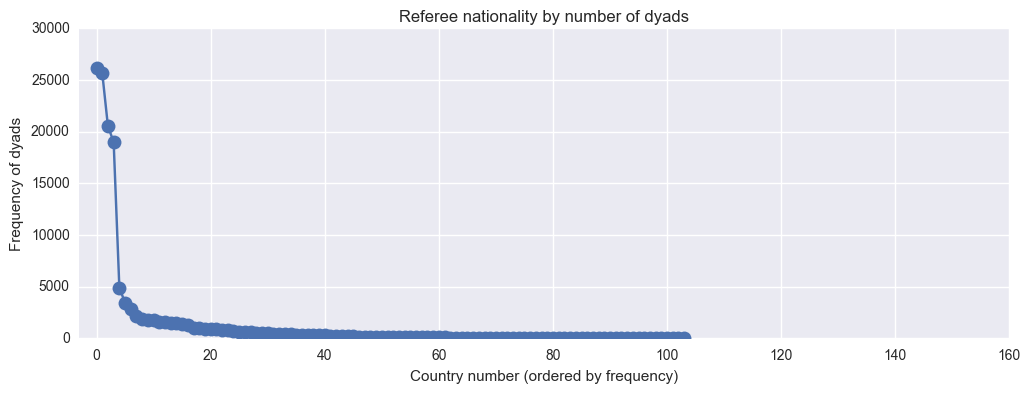

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df_sup21_tot.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist() 

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

(-3, 160)

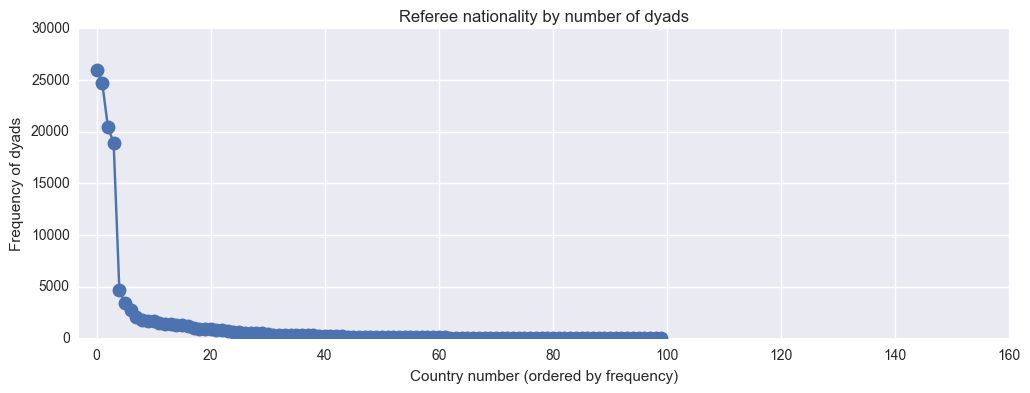

In [41]:
# Histogram of country frequency. 
fig, ax = plt.subplots(1,1,figsize=(12, 4))
x = df_sup21_once_player.refCountry.value_counts()
lines = ax.plot(x.values,marker='.',ms=20)

y = x.index.tolist()

ax.set_title('Referee nationality by number of dyads')
ax.set_xlabel('Country number (ordered by frequency)')
ax.set_ylabel('Frequency of dyads')
ax.set_xlim([-3,160]) # a hack so we can see the first point most clearly

Here we see that our method reduces the number of total countries but doesn't change the frequency of dyads with the most represented countries compared to the previous graph

## Removing non usable data for our ML algorithm

We know sometimes there is no images for a player and therefor no skin color rating. Therefore we remove them.

In [28]:
df_with_pic = df_sup21_once_player[df_sup21_once_player["photoID"].notnull()]

In [29]:
df_sup21_once_player.shape[0]

133501

In [30]:
df_with_pic.shape[0]

113862

Should be all clean now.

In [31]:
dfc = df_with_pic

## Aggregating the data by player

In [32]:
dfc.describe()

/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,113839.000000,113237.000000,113862.000000,113862.00000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113862.000000,113752.000000,1.137520e+05,1.137520e+05,113752.000000,1.137520e+05,113752.000000
mean,182.095688,76.312742,3.127549,1.39511,0.748722,0.983717,0.364002,0.417813,0.012664,0.013200,0.263685,0.302730,1525.012638,28.473968,0.348303,1.798495e+04,4.630137e-04,0.462503,1.866079e+04,0.002274
std,6.790061,7.161171,3.696489,1.93970,1.176301,1.464330,0.968767,0.844619,0.113846,0.115964,0.294763,0.292258,918.024487,27.101513,0.029085,1.206506e+05,2.377432e-03,0.199049,1.239635e+05,0.012400
min,161.000000,54.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,-0.047254,7.000000e+00,2.235373e-07,-1.375000,8.000000e+00,0.000001
25%,NaN,NaN,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,640.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,1572.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,4.000000,2.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.500000,2331.000000,44.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,203.000000,100.000000,47.000000,29.00000,14.000000,18.000000,23.000000,14.000000,3.000000,2.000000,1.000000,1.000000,3147.000000,153.000000,0.573793,1.975803e+06,7.333041e-02,1.800000,2.029548e+06,0.329309


Let's look at a single players dyad to have an idea of what it looks like

In [33]:
groups = dfc.groupby("playerShort")

In [34]:
lucas = groups.get_group("lucas-wilchez")

In [35]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
lucas.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
2782,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,3,1,1,1,0
3384,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
5692,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,1,0,0,0
9058,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,2,2,0,0,0
14886,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,1,0,0


In [36]:
# Taken form http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb 
lucas.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
2782,0,0,0,95212.jpg,0.25,0.5,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3384,0,0,0,95212.jpg,0.25,0.5,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5692,0,0,0,95212.jpg,0.25,0.5,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
9058,1,0,0,95212.jpg,0.25,0.5,214,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
14886,0,0,0,95212.jpg,0.25,0.5,313,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696


First we will only keep the columns that seem relevant to us and remove the ones we think are not important :
- player name which is a repetition of the playershort
- birthday as it should not be relevant, completely independent (that would be weird al least :))
- refNum, refCountry, Alpha3 which are not easily usable as an aggregated feature (a solution to use this part of the data will be detailed later)
- nIAT and nExp really not relevant here 
    we could do a weihted mean with the "mean" and "se" columns but it seemed a bit exagerated (could be a futur improvement ?)
    
Why we kept other columns is explained below with the aggregation operation.

In [37]:
# We only keep what we think are relevant columns.
df_filtered = dfc[["playerShort","club", "leagueCountry", "height", "weight", "position", "games", "victories", 
                 "ties", "defeats", "goals", "yellowCards", "yellowReds", "redCards",
                 "rater1", "rater2", "meanIAT", "seIAT", "meanExp", "seExp"]]

In [42]:
df_grouped = df_filtered.groupby("playerShort").agg({
        "club": lambda x: x.unique()[0],
        "leagueCountry": lambda x: x.unique()[0],
        "height": np.max,
        "weight": np.max,
        "position": lambda x: x.unique()[0],
        "games": np.sum,
        "victories": np.sum,
        "ties": np.sum,
        "defeats": np.sum,
        "goals": np.sum,
        "yellowCards": np.sum,
        "yellowReds": np.sum,
        "redCards": np.sum,
        "rater1": np.max, # never changes so we can take either min, max or mean 
        "rater2": np.max, # same here (we used this to test that nothing changed : [np.min, np.max, np,mean])
        "meanIAT": np.mean, # Here doing the mean seems a bit confusing but it will give an 
        "seIAT": np.mean,   # indicatiion whether the player could have been mistreated in 
                            # some of his matches or never.
        "meanExp": np.mean, # Same here
        "seExp": np.mean    # We could have applied pooled variance (will see later) : https://en.wikipedia.org/wiki/Pooled_variance
    })

In [43]:
# We used this to check wether min and max rating change for each player (which was not the case)
#df_grouped[df_grouped["rater1", "amin"] != df_grouped["rater1", "amax"]]

In [44]:
# We used this to test if some players had multiple clubs, league country or position. Which was not the case.
#print(df_grouped["club"].apply(lambda x: x[0].shape).unique())
#print(df_grouped["leagueCountry"].apply(lambda x: x[0].shape).unique())
#print(df_grouped["position"].apply(lambda x: x[0].shape).unique())

In [45]:
df_grouped.head()

,meanIAT,position,games,meanExp,seIAT,rater1,goals,yellowReds,ties,defeats,redCards,leagueCountry,weight,rater2,height,yellowCards,seExp,club,victories
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.344759,Center Back,641,0.487879,0.000333,0.25,9,0,176,222,0,England,71.0,0.00,182.0,19,0.001553,Fulham FC,243
aaron-hunt,0.349332,Attacking Midfielder,329,0.453989,0.000226,0.00,59,0,70,119,1,Germany,73.0,0.25,183.0,39,0.001025,Werder Bremen,140
aaron-lennon,0.345893,Right Midfielder,412,0.491482,0.000367,0.25,31,0,97,115,0,England,63.0,0.25,165.0,11,0.002032,Tottenham Hotspur,200
aaron-ramsey,0.346790,Center Midfielder,254,0.511650,0.000525,0.00,39,0,42,67,1,England,76.0,0.00,178.0,31,0.002938,Arsenal FC,145
abdelhamid-el-kaoutari,0.331600,Center Back,124,0.335587,0.001488,0.25,1,4,40,43,2,France,73.0,0.25,180.0,8,0.005296,Montpellier HSC,41


In [46]:
len(df_grouped)

1584

Thanks to the description of the data in DATA.md we know there should be 1586 players with pictures.
With this value we can validate the fact that we lost minimal data and have most of the players with a picture.

## Preparing Data

As a last step before starting to do machine learning we need to reformat the data and seperate it

First we need to make rows which contain strings in integers (club, position, leagueCountry)

In [47]:
from sklearn import preprocessing

df_grouped["club"] = df_grouped["club"].astype(np.str)
df_grouped["position"] = df_grouped["position"].astype(np.str)
df_grouped["leagueCountry"] = df_grouped["leagueCountry"].astype(np.str)

def encodeLabels(col, df):
    le = preprocessing.LabelEncoder()
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

encodeLabels("club", df_grouped)
encodeLabels("position", df_grouped)
encodeLabels("leagueCountry", df_grouped)

Now we can create the futur x and y for training

In [48]:
y_possible = df_grouped[["rater1","rater2"]]
y_possible.head()

,rater1,rater2
playerShort,,
aaron-hughes,0.25,0.00
aaron-hunt,0.00,0.25
aaron-lennon,0.25,0.25
aaron-ramsey,0.00,0.00
abdelhamid-el-kaoutari,0.25,0.25


In [49]:
x = df_grouped.drop(y_possible, axis=1)
x.head()

,meanIAT,position,games,meanExp,seIAT,goals,yellowReds,ties,defeats,redCards,leagueCountry,weight,height,yellowCards,seExp,club,victories
playerShort,,,,,,,,,,,,,,,,,
aaron-hughes,0.344759,1,641,0.487879,0.000333,9,0,176,222,0,0,71.0,182.0,19,0.001553,34,243
aaron-hunt,0.349332,0,329,0.453989,0.000226,59,0,70,119,1,2,73.0,183.0,39,0.001025,90,140
aaron-lennon,0.345893,10,412,0.491482,0.000367,31,0,97,115,0,0,63.0,165.0,11,0.002032,82,200
aaron-ramsey,0.346790,3,254,0.511650,0.000525,39,0,42,67,1,0,76.0,178.0,31,0.002938,6,145
abdelhamid-el-kaoutari,0.331600,1,124,0.335587,0.001488,1,4,40,43,2,1,73.0,180.0,8,0.005296,51,41


In [50]:
def prepFeature(feature) :
    nans = True in x[feature].isnull().unique()
    
    if nans:
        print("mean replacement of nans")
        x[feature] = x[feature].fillna(int(x[feature].mean()))
    
    f, ax = plt.subplots(1, 1)
    ax.set_title("histogram of feature " + feature)
    ax.hist(x[feature].values)

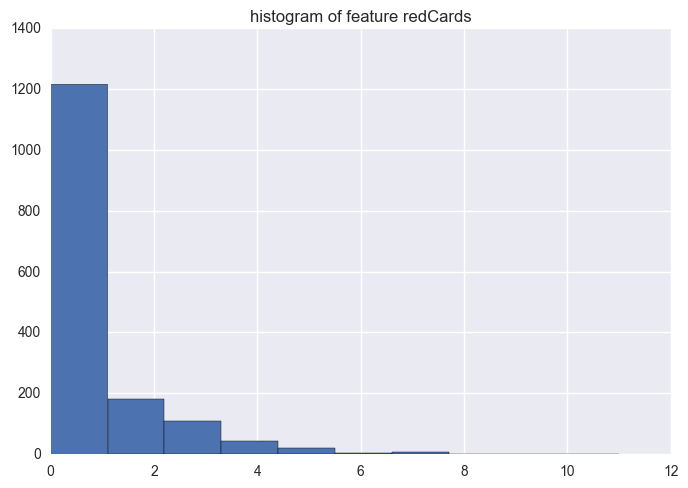

In [51]:
prepFeature("redCards")

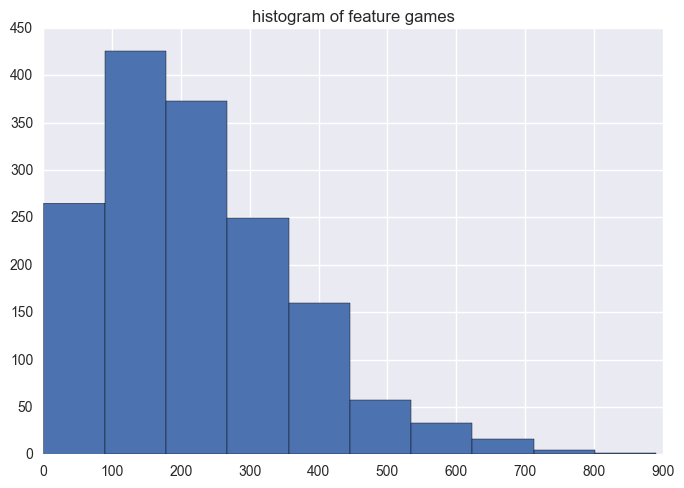

In [52]:
prepFeature("games")

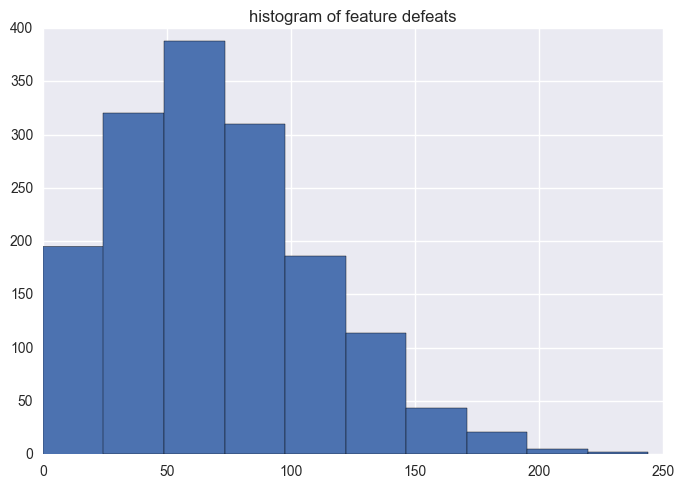

In [53]:
prepFeature("defeats")

mean replacement of nans


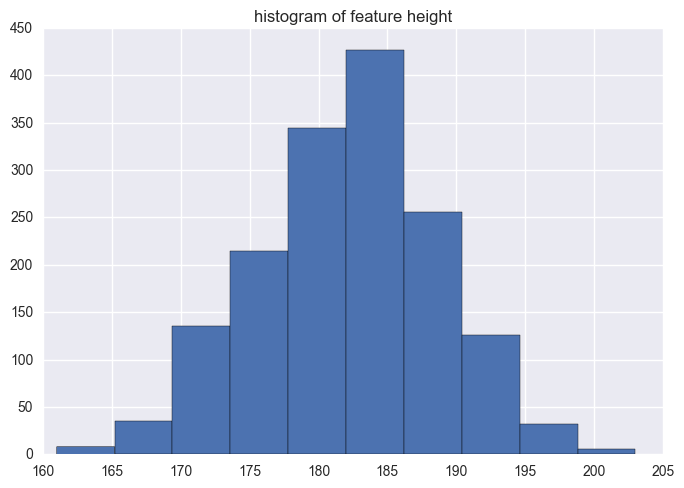

In [54]:
prepFeature("height")

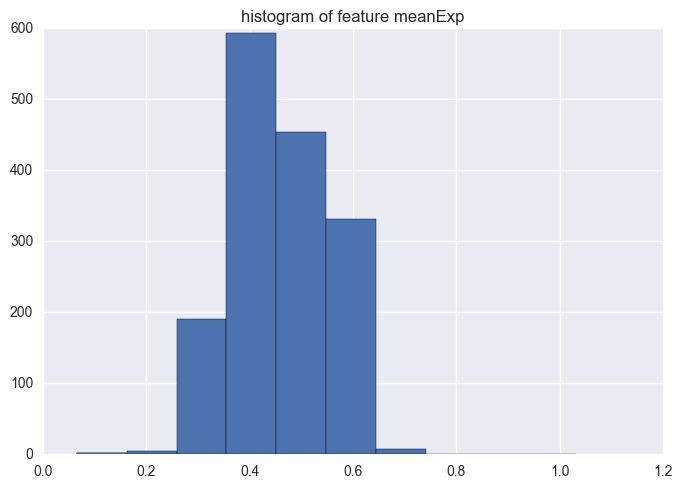

In [55]:
prepFeature("meanExp")

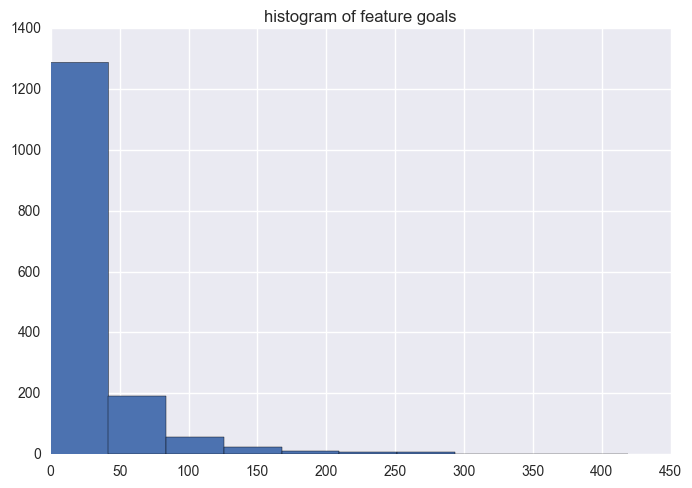

In [56]:
prepFeature("goals")

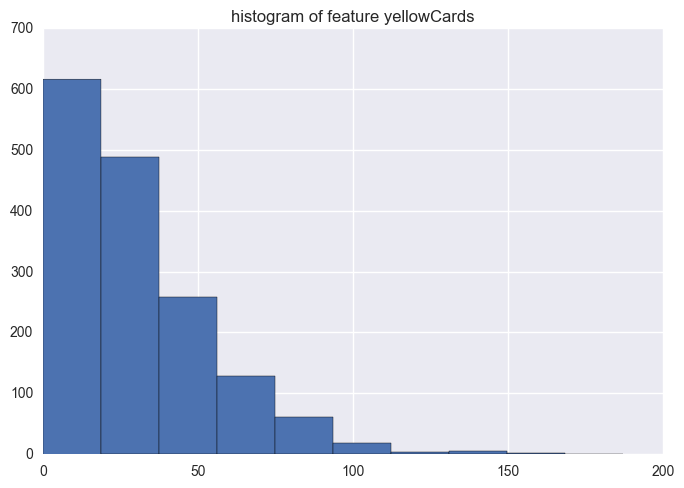

In [57]:
prepFeature("yellowCards")

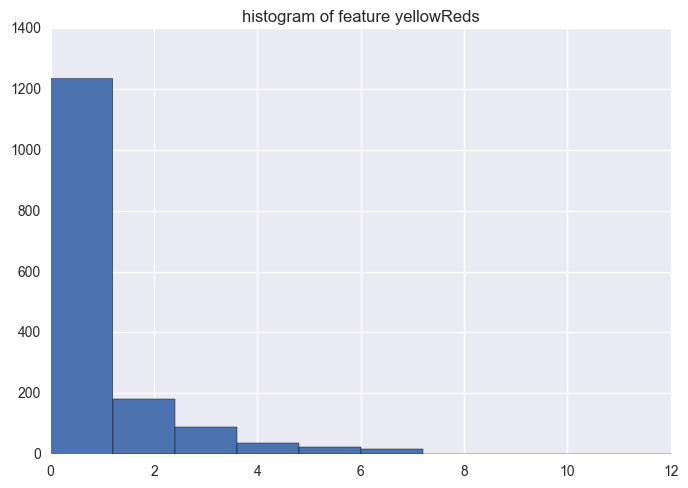

In [58]:
prepFeature("yellowReds")

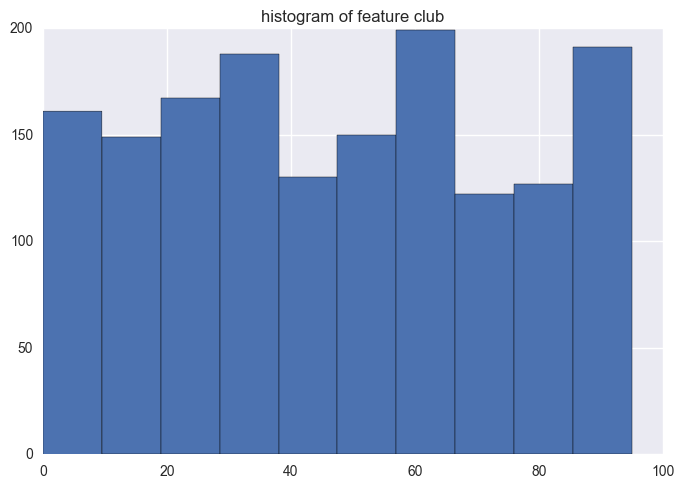

In [59]:
prepFeature("club")

mean replacement of nans


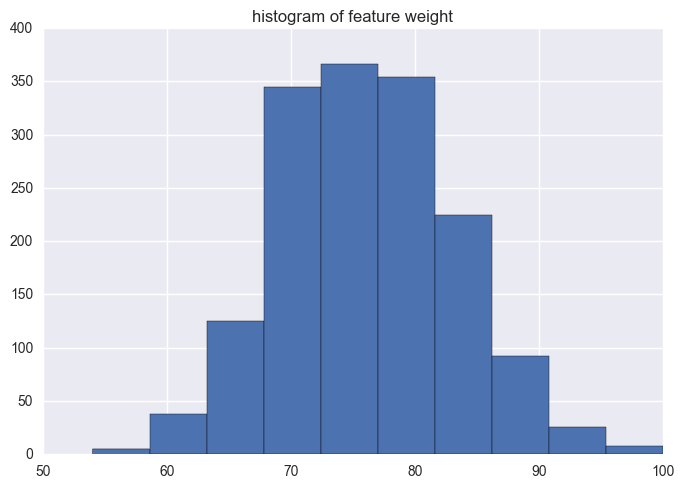

In [60]:
prepFeature("weight")

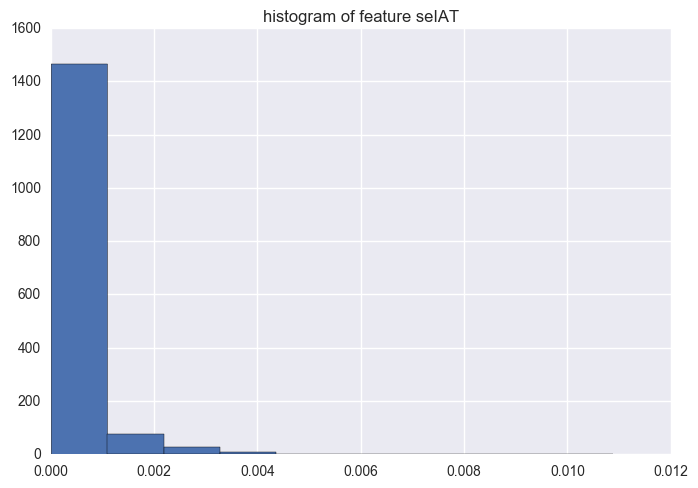

In [61]:
prepFeature("seIAT")

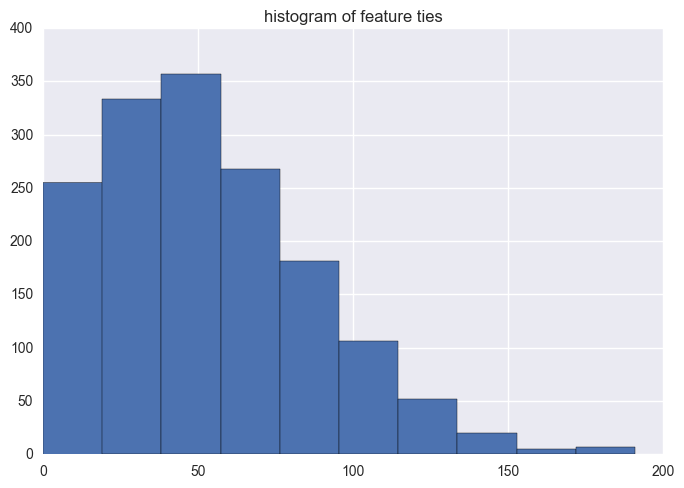

In [62]:
prepFeature("ties")

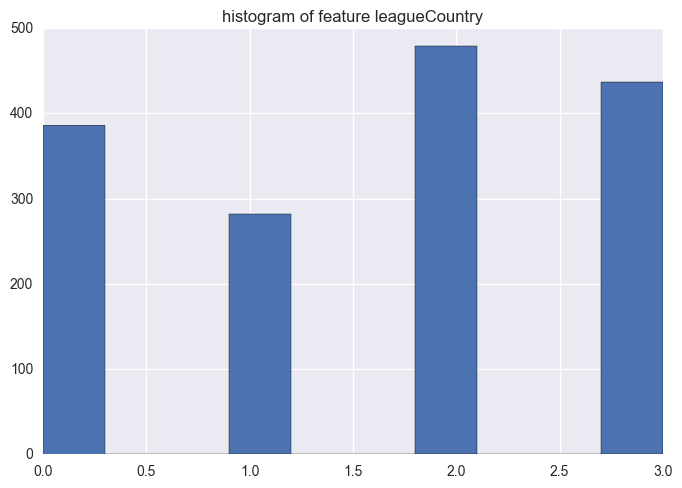

In [63]:
prepFeature("leagueCountry")

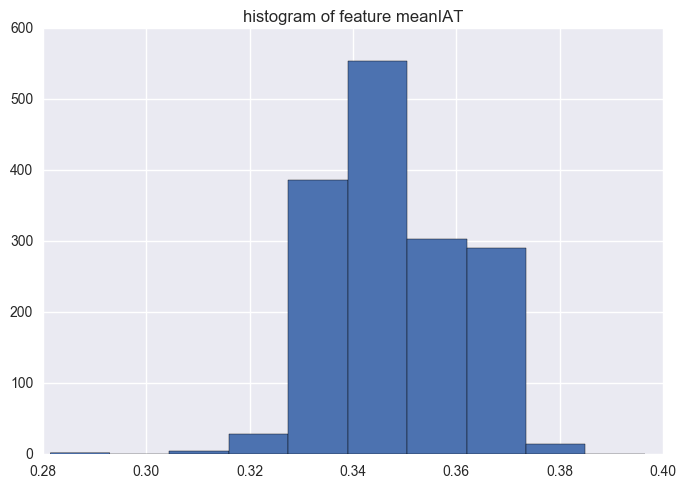

In [64]:
prepFeature("meanIAT")

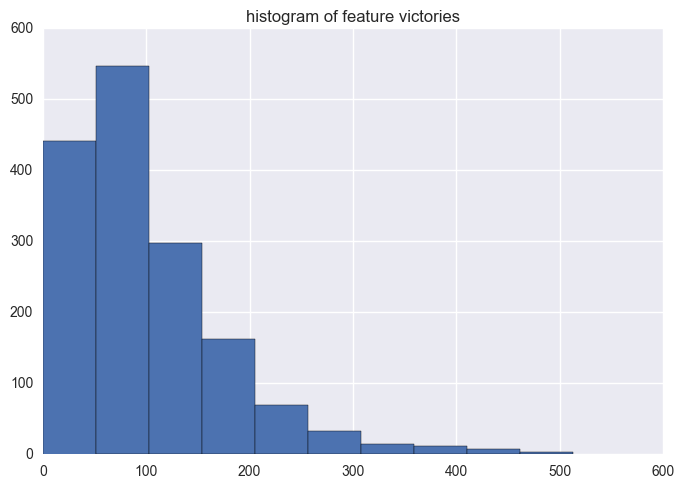

In [65]:
prepFeature("victories")

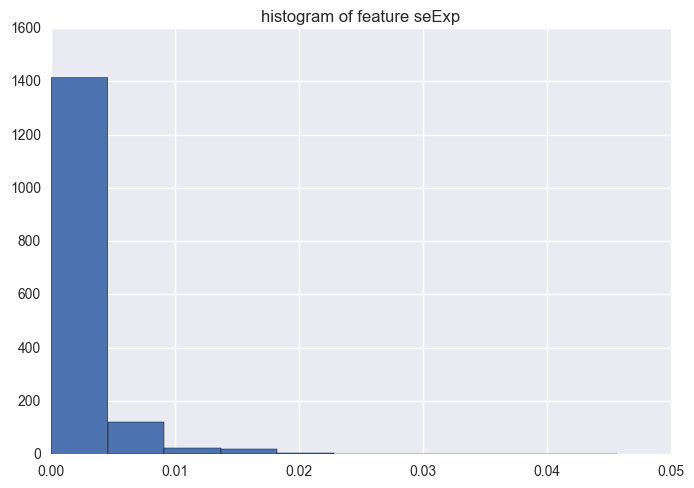

In [66]:
prepFeature("seExp")

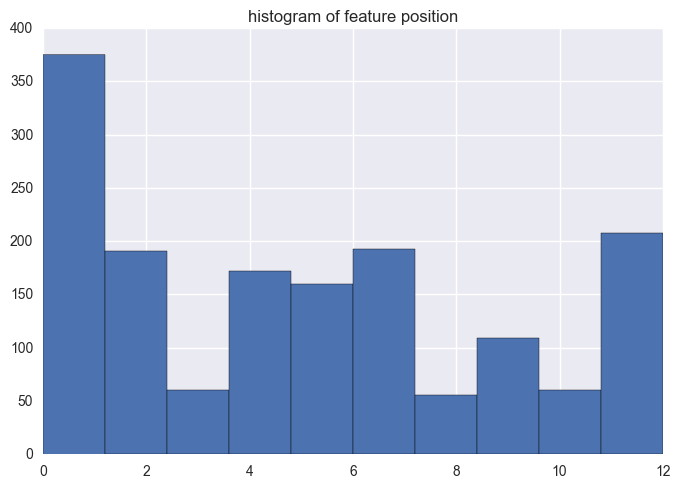

In [67]:
prepFeature("position")

## Naive machine learning

In [70]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics

In [71]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

Let's build y (in a naive fashion for now)

In [80]:
y = (y_possible['rater1'] + y_possible['rater2'] / 2 < 0.5).values

In [74]:
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [75]:
y_pred = rfc.predict(x)

In [76]:
print(metrics.mean_absolute_error(y, y_pred))
print(metrics.accuracy_score(y, y_pred))

0.0183080808081
0.981691919192


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


### Ok so we're done here ! 99% seems reasonable, goodbye !

## Ok just kidding let's get serious with this !

First let's really test the naive approach and see how it could perform in a "real" situation.

let's first split the dataset into a training and testing set. This seems to be generally a good practice in machine learning :).

In [149]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [150]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

In [151]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [152]:
y_pred = rfc.predict(x_test)

In [153]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.249211356467
0.750788643533


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Ok that's kind of disapointing... (but not so much suprising)

Let's try to use some well known ML technics to understand what's going wrong.

In [162]:
#rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

In [163]:
# Cross validation 10-Fold (for now) with accuracy scoring
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(rfc, x, y, cv=5, scoring='accuracy')

In [164]:
def show_score(scores):
    print(scores)
    print("--------------------------")
    print("mean :", np.mean(scores))
    print("min :", np.min(scores))
    print("max :", np.max(scores))

show_score(scores)

[ 0.70440252  0.66981132  0.71518987  0.6835443   0.73101266]
--------------------------
mean : 0.700792134384
min : 0.669811320755
max : 0.731012658228


We can see again that the result is not pretty, the best result we have is ~73% which is not much better than perdicting that all players are light skinned

proportions of classes for the mean rating (considering 1 -> $mean \leq 0.5$)

In [165]:
# Proportion of light and dark skinned players
prop_1 = np.sum(y) / len(y)
prop_0 = 1 - prop_1
print("proportion of ones :", prop_1)
print("proportion of zeroes :", prop_0)

proportion of ones : 0.708333333333
proportion of zeroes : 0.291666666667


Ok now let's see what the confusion matrix has to say.

In [166]:
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
TP = confusion_mx[1, 1]
TN = confusion_mx[0, 0]
FP = confusion_mx[0, 1]
FN = confusion_mx[1, 0]

In [167]:
confusion_mx

array([[ 37,  53],
       [ 26, 201]])

|total : 317| pred : 0 |  pred : 1  |
|---|----|-----|
| actual : 0 | TN = 37 | FP = 53 |
| actual : 1 | FN = 26 | TP = 201 |

We can see here that we are good at predicting ones, but our predictions of 0 are all over the place.

There is an easy way to show this : the **Specificity** (or how correct is the classifier with 0 values)

In [176]:
specificity = TN / float(TN + FP)
print("Specificity :", specificity)

Specificity : 0.411111111111


We can compare it to **Sensitivity** (or true positive rate)

In [169]:
sensitivity = TP / float(TP + FN)
print("sensitivity :", sensitivity)

sensitivity : 0.885462555066


Which is much better. 

PS : all these methods are taken from the course and the calculations were found in this notebook : http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

So, how are we going to do a better job ?

The first thing we realize is that there is a way to indicate to the random forest classifier the fact that there is a disparity within the data.

In [193]:
class_weights = {
    1 : prop_1*10,
    0 : prop_0*10
}

In [190]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=class_weights)

We will use a function that prints out most of the information we used above to test our new rfc 

In [200]:
from helpers import test_rfc
test_rfc(rfc, x, y)

Cross validation scores
[ 0.7327044   0.6918239   0.72151899  0.69620253  0.73417722]
--------------------------
cross mean : 0.715285407213
cross min : 0.691823899371
cross max : 0.73417721519
----------
TP : 193
TN : 37
FP : 53
FN : 34
----------
specificity : 0.411111111111
sensitivity : 0.850220264317


Ok, to bad it's not better than before althought our sensitivity is a bit lower (which is reasonable)

Let's try something else : changing the classification threshold

We think this will help the **specificity** get higher.

let's retrain our data with our new rfc (with weights)

# NE RUN PAS ce qu'il y a en dessous de ça

In [201]:
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [206]:
y_pred_prob = rfc.predict_proba(x_test)[:, 1]

In [207]:
y_pred * y_pred_prob

array([ 0.7,  0.6,  0. ,  0.8,  0.8,  0.7,  0.9,  0.6,  1. ,  0.7,  0.7,
        0.8,  1. ,  0.9,  0.7,  0.9,  0.6,  0.9,  1. ,  0. ,  0. ,  0.9,
        0.8,  0.6,  0.6,  0.7,  0.6,  0.9,  0.9,  1. ,  0.9,  0.7,  0.7,
        0.8,  0.8,  0.7,  0.8,  0.9,  1. ,  0. ,  0. ,  1. ,  0.7,  0.8,
        0.9,  0.8,  0.9,  1. ,  1. ,  1. ,  0.7,  0. ,  0. ,  1. ,  0. ,
        0.9,  0.8,  0.7,  1. ,  0. ,  0. ,  1. ,  1. ,  1. ,  0.7,  0.9,
        0.6,  0. ,  0.7,  0.7,  0.6,  0.6,  0. ,  0.9,  0.6,  0.7,  0. ,
        0. ,  0. ,  0.8,  0.8,  0.9,  0.7,  0.8,  0.9,  0. ,  0. ,  0.6,
        0.8,  0. ,  0. ,  0.7,  0. ,  0.9,  0.9,  0.8,  0. ,  1. ,  1. ,
        0.7,  0.6,  0.7,  0.7,  0.9,  0.6,  0.8,  0.6,  0.9,  0. ,  0. ,
        0.6,  0.7,  0.9,  0.8,  1. ,  0.9,  0.9,  0.7,  0.9,  0.6,  0.9,
        0.6,  1. ,  0.8,  0.8,  0.6,  0.9,  0.9,  0.6,  0.7,  0.7,  0.8,
        1. ,  0. ,  1. ,  0.8,  0.9,  1. ,  0.9,  0.8,  0.8,  0.8,  0.8,
        0.8,  0.8,  0. ,  0.8,  0.7,  0.9,  1. ,  0

In [ ]:
y_pred_prob_1 = 

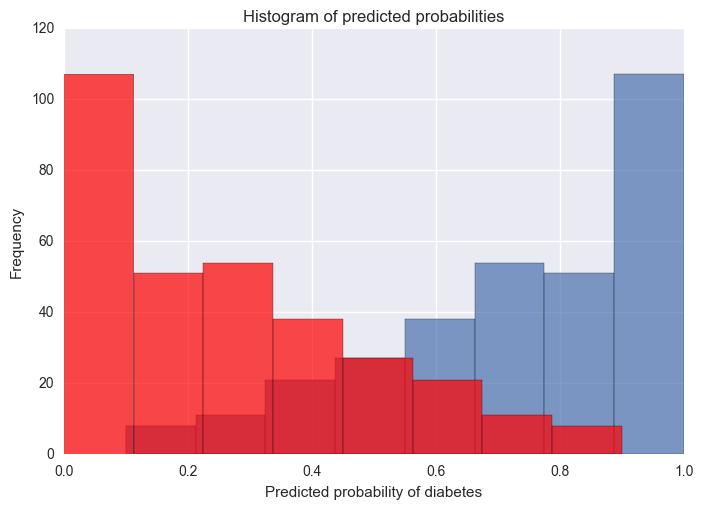

In [205]:
# histogram of predicted probabilities
plt.hist(y_pred_prob_1, bins=8, alpha=0.7)
plt.hist(y_pred_prob_0, bins=8, alpha=0.7, color="red")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

### Some tips and tricks from the lab session.

In [ ]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [ ]:
# STEP 1: split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [ ]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], data[1]))

In [ ]:
from sklearn.cross_validation import cross_val_score
# 10-fold cross-validation
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')

In [ ]:
from sklearn.grid_search import GridSearchCV

# define the parameter values that should be searched
k_range = list(range(1, 31))

# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

#You can set n_jobs = -1 to run computations in parallel (if supported by your computer and OS

# fit the grid with data
grid.fit(X, y)

# view the complete results (list of named tuples)
grid.grid_scores_

# create a list of the mean scores only
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print(grid_mean_scores)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X, y)
rand.grid_scores_

In [ ]:
from sklearn import metrics
print(metrics.mean_absolute_error(true, pred))

# calculate RMSE using scikit-learn
print(np.sqrt(metrics.mean_squared_error(true, pred)))

print(metrics.accuracy_score(y_test, y_pred))

# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

# Sensitivity : Recall or True Positive Rate
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

# Specificity score (how precise is the classifier for positive value)
print(TN / float(TN + FP))

# Flase positive Rate 
print(FP / float(TN + FP))

# Precision, true positive rate.
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

In [ ]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.3)[0]

# IMPORTANT: first argument is true values, second argument is predicted probabilities
# Plot of the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)